# Kaggle Competition - Solar PV in Aerial Imagery

## *Team 8: Pinkies*
Yuan Feng [yf115]\
Sebastián Soriano Pérez [ss1072]\
Vishaal Venkatesh [vv58]\
Abhiraj Vinnakota [agv9]\
Roderick Whang [rjw34]

## 1. Jupyter Notebook Setup

Importing all necessary packages and additional setups for this notebook to run properly.

In [1]:
'''
Import packages
'''
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
import sklearn.metrics as metrics
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
from pylab import rcParams
import warnings
warnings.filterwarnings('ignore')
plt.close()

In [2]:
# For clearer plots in Jupyter notebooks on macs, run the following line of code:
%config InlineBackend.figure_format = 'retina'

In [3]:
'''
Set directory parameters
'''
# Set the directories for the data and the CSV files that contain ids/labels
dir_train_images  = '../data/training/'
dir_test_images   = '../data/testing/'
dir_train_labels  = '../data/labels_training.csv'
dir_test_ids      = '../data/sample_submission.csv'

## 2. Function Definition

Definition of every function needed to load the datasets, preprocess the data and extract features, define the classigication models, test the cross validated performance of the models, and plot the performance metrics.

In [4]:
def load_data(dir_data, dir_labels, training = True):
    '''
    Load each of the image files into memory
    
    When training = True, the labels are also loaded
    '''
    labels_pd = pd.read_csv(dir_labels)
    ids       = labels_pd.id.values
    data      = []
    
    for identifier in ids:
        fname     = dir_data + identifier.astype(str) + '.tif'
        image     = mpl.image.imread(fname)
        data.append(image)
        
    data = np.array(data) # Convert to Numpy array
    
    if training:
        labels = labels_pd.label.values
        return data, labels
    
    else:
        return data, ids

In [5]:
def preprocess_and_extract_features(data, prc):
    '''
    Preprocess data and extract features
    
    Preprocess: normalize, scale, repair
    Extract features: transformations and dimensionality reduction
    
    data: X matrix of images/features
    prc: string for selected features extraction process -> 'colors', 'HOG'
    '''
    if prc == 'color':
        # Filter images to keep only colors in the optimal range found at the end of this notebook
        
        color_lo = np.asarray([0, 0, 110])   # Lower color
        color_hi = np.asarray([55, 87, 187]) # Higher color
        new_data = []                        # Empty list with new features (average color values for RGB channels)
        
        for img in data:
            # Iterate over every image in set
            
            img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            mask = cv2.inRange(img_hsv, color_lo, color_hi) # Create mask of pixels that are inside the color range
            mask[mask != 0] = 1                             # Keep colors, turns every non black pixel into 1
            mask = np.expand_dims(mask, axis = 2)
            mask = np.append(
                np.append(mask, mask, axis = 2), 
                mask, 
                axis = 2
            )
            feature = img * mask                            # Turns every pixel outside the range into 0
            
            if np.count_nonzero(feature) != 0: 
                # Extract average color value on RGB channels for non-zero pixels
                
                feature = np.sum(np.sum(feature, axis = 0), axis = 0) / np.count_nonzero(feature)
                
            else:
                # If no color is inside range, sets average color values for RGB channels as 255 (white)
                
                feature = [255, 255, 255]

            new_data.append(feature)                        # Appends features to list
        
        features = np.array(new_data)

        return features
    
    elif prc == 'HOG':
        # Runs Histogram of Gradients feature extraction process to detect edges on images
        
        get_hog = lambda X: hog(X, orientations = 9, pixels_per_cell = (16, 16),
                                cells_per_block = (4, 4), visualize = False, multichannel = True)
        features = np.array([get_hog(image) for image in data])

        return features
    
    elif prc == 'NA':
        return data

In [6]:
def set_classifier(clf):
    '''
    Shared function to select the classifier for both performance evaluation and testing
    '''
    if clf == 'knn':
        return KNeighborsClassifier(n_neighbors = 7)
    
    elif clf == 'logistic':
        return LogisticRegression(solver = 'liblinear')
    
    elif clf == 'dummy':
        return DummyClassifier(strategy = 'uniform')

In [7]:
def cv_performance_assessment(X, y, k, clf, prc):
    '''
    Cross validated performance assessment
    
    X   = training data
    y   = training labels
    k   = number of folds for cross validation
    clf = classifier to use
    prc = feature extraction process
    
    Divide the training data into k folds of training and validation data. 
    For each fold the classifier will be trained on the training data and
    tested on the validation data. The classifier prediction scores are 
    aggregated and output
    '''
    # Establish the k folds
    
    prediction_scores = np.empty(y.shape[0], dtype = 'object')
    kf = StratifiedKFold(n_splits = k, shuffle = True)
    
    for train_index, val_index in kf.split(X, y):
        # Extract the training and validation data for this fold
        
        X_train_l, X_val = X[train_index], X[val_index]
        y_train_l        = y[train_index]
        
        # Train the classifier
        
        X_train_features = preprocess_and_extract_features(X_train_l, prc)        
        clf = clf.fit(X_train_features, y_train_l)
        
        # Test the classifier on the validation data for this fold
        
        X_val_features = preprocess_and_extract_features(X_val, prc)
        cpred = clf.predict_proba(X_val_features)
        
        # Save the predictions for this fold
        
        prediction_scores[val_index] = cpred[:, 1]
        
    return prediction_scores

In [8]:
def plot_roc(labels, prediction_scores, legend, color):
    '''
    Function to plot ROC curve
    '''
    fpr, tpr, _   = metrics.roc_curve(labels, prediction_scores, pos_label = 1)
    auc           = metrics.roc_auc_score(labels, prediction_scores)
    legend_string = legend + ' (AUC = {:0.3f})'.format(auc)  
    plt.plot(fpr, tpr, label = legend_string, color = color)

In [9]:
def plot_prc(labels, prediction_scores, legend, color):
    '''
    Function to plot PRC curve
    '''
    precision, recall, thresholds = precision_recall_curve(labels, prediction_scores)
    average_precision = average_precision_score(labels, prediction_scores)
    legend_string = legend + ' (AP = {:0.3f})'.format(average_precision)  
    plt.plot(recall, precision, label = legend_string, color = color)

In [10]:
def get_threshold(labels, prediction_scores):
    '''
    Returns the best threshold cutoff
    '''
    fpr, tpr, threshold = metrics.roc_curve(labels, prediction_scores)
    i                   = np.arange(len(tpr))
    roc                 = pd.DataFrame(
        {'tf': pd.Series(tpr - (1 - fpr), index = i), 'threshold': pd.Series(threshold, index = i)}
    )
    roc_t               = roc.iloc[(roc.tf - 0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

## 3. Model Fitting and Performance Cross Validation

Performance Cross validation for every model used.

In [11]:
'''
Loading data
'''
X_train, y_train = load_data(dir_train_images, dir_train_labels)
X_test, ids_test = load_data(dir_test_images, dir_test_ids, training = False)

X_train, y_train = shuffle(X_train, y_train)

In [12]:
'''
Random Model
'''
# Set parameters for the analysis
clf0 = set_classifier('dummy')
clf0.fit(X_train, y_train)
prediction_scores0 = clf0.predict(X_train)

In [13]:
'''
Model 1: Cross validated performance for Color Filtering KNN Model
'''
# Set parameters for the analysis
num_training_folds1 = 10
clf1 = set_classifier('knn')
prc1 = 'color'

# Perform cross validated performance assessment
prediction_scores1 = cv_performance_assessment(X_train, y_train, num_training_folds1, clf1, prc1)

In [14]:
'''
Model 2: Cross validated performance for HOG KNN Model
'''
# Set parameters for the analysis
num_training_folds2 = 10
clf2 = set_classifier('knn')
prc2 = 'HOG'

# Perform cross validated performance assessment
prediction_scores2 = cv_performance_assessment(X_train, y_train, num_training_folds2, clf2, prc2)

In [15]:
'''
Model 3: Cross validated performance for Ensemble Logistic Model
'''
# Create training features Z with predictions scores from Model 1 and Model 2
Z_train = np.stack((prediction_scores1, prediction_scores2), axis = -1)

# Set parameters for the analysis
num_training_folds3 = 10
clf3 = set_classifier('logistic')
prc3 = 'NA'

# Perform cross validated performance assessment
prediction_scores3 = cv_performance_assessment(Z_train, y_train, num_training_folds3, clf3, prc3)

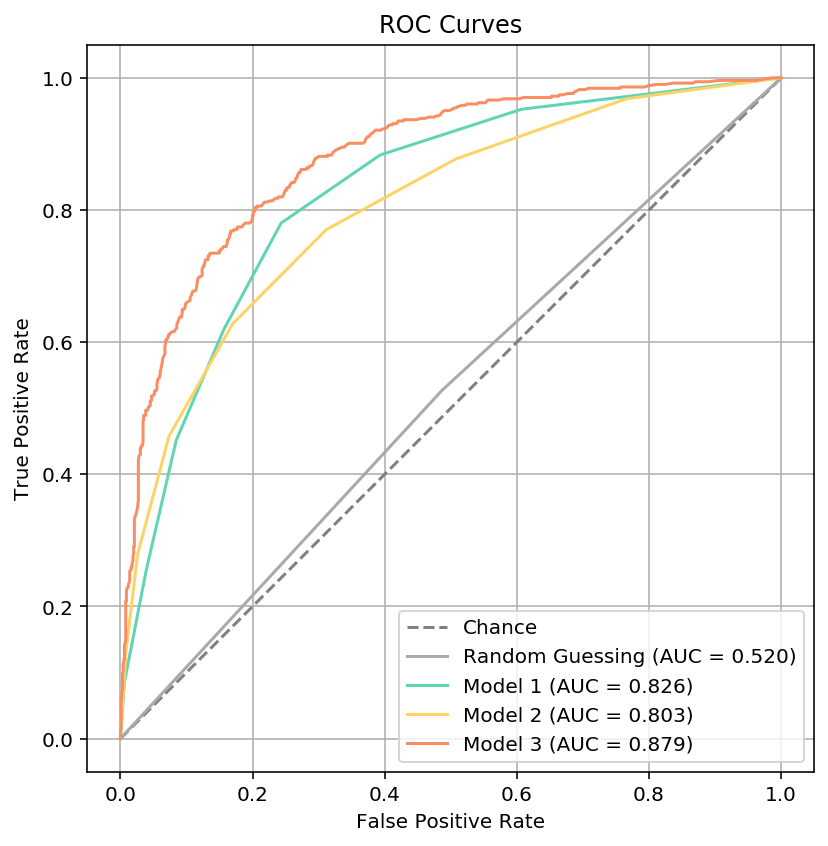

In [51]:
'''
Plotting ROC Curves for Cross-Validated Performance
'''
# Compute and plot the ROC curves
plt.figure(figsize = (6, 6))
plt.title('ROC Curves')
plt.plot([0, 1], [0, 1], '--', color = 'gray', label = 'Chance')

# Plot ROC for each model
plot_roc(y_train, prediction_scores0, legend = 'Random Guessing', color = 'darkgray')
plot_roc(y_train, prediction_scores1, legend = 'Model 1', color = '#61d4b3')
plot_roc(y_train, prediction_scores2, legend = 'Model 2', color = '#fdd365')
plot_roc(y_train, prediction_scores3, legend = 'Model 3', color = '#fb8d62')
#plot_roc(y_train, prediction_scores4, legend = 'Model 4', color = '#fd2eb3')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid('on')
plt.axis('square')
plt.legend()
plt.tight_layout()

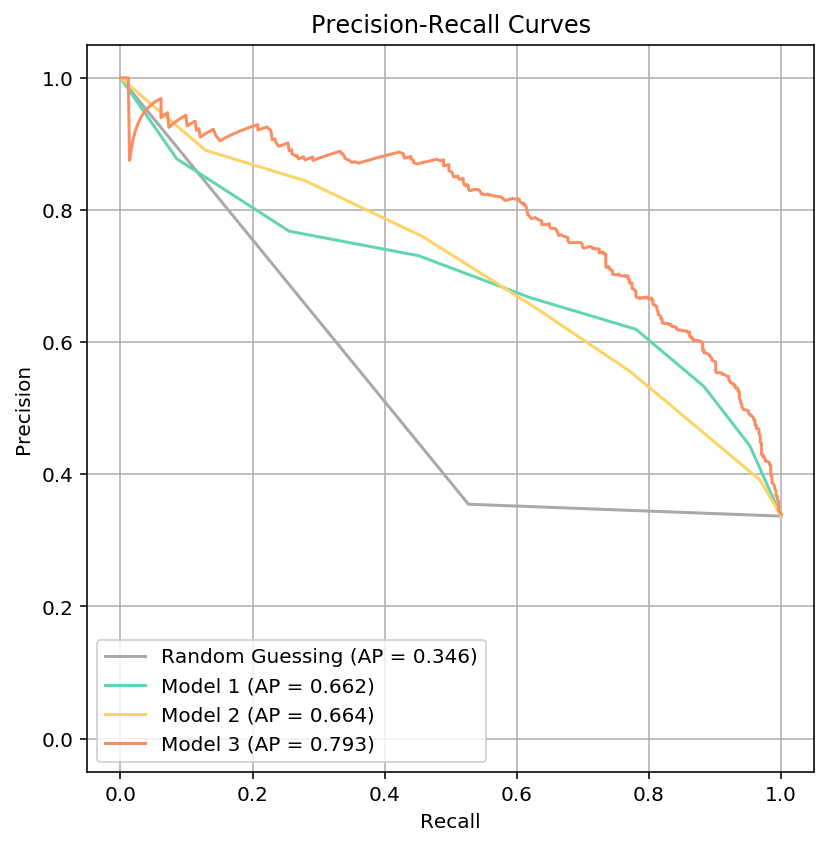

In [49]:
'''
Plotting PRC Curves for Cross-Validated Performance
'''
# Compute and plot the PRC curves
plt.figure(figsize = (6, 6))
plt.title('Precision-Recall Curves')

# Plot ROC for each model
plot_prc(y_train, prediction_scores0, legend = 'Random Guessing', color = 'darkgray')
plot_prc(y_train, prediction_scores1, legend = 'Model 1', color = '#61d4b3')
plot_prc(y_train, prediction_scores2, legend = 'Model 2', color = '#fdd365')
plot_prc(y_train, prediction_scores3, legend = 'Model 3', color = '#fb8d62')
#plot_prc(y_train, prediction_scores4, legend = 'Model 4', color = '#fd2eb3')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid('on')
plt.axis('square')
plt.ylim(-0.05, 1.05)
plt.legend()
plt.tight_layout()

## 4. Model Fitting and Performance on Validation Set

Performance on a new validation set for every model used. The validation set was created by splitting the training data (with 25% of the sample images).

In [18]:
'''
Splitting data to create validation set
'''
split              = 0.75
X_train2, y_train2 = X_train[:int(X_train.shape[0] * split)], y_train[:int(X_train.shape[0] * split)]
X_val, y_val       = X_train[int(X_train.shape[0] * split):], y_train[int(X_train.shape[0] * split):]

In [19]:
'''
Random Model
'''
# Set parameters for the analysis
clf0v = set_classifier('dummy')
clf0v.fit(X_train2, y_train2)
prediction_scores0v = clf0v.predict(X_val)
prediction_scores0t = clf0v.predict(X_train2)

# Finding optimal threshold and printing confusion matrix
cutoff0       = get_threshold(y_val, prediction_scores0v)
predictions0v = np.copy(prediction_scores0v)

print('Model 0 optimal cuttof is {}'.format(cutoff0[0]))
pd.DataFrame(confusion_matrix(y_val, predictions0v))

Model 0 optimal cuttof is 1


,0,1
0,125,124
1,63,63


In [20]:
'''
Model 1: Performance on Validation set for color filtering KNN
'''
# Fitting model
clf1v              = set_classifier('knn')
prc1v              = 'color'
X_train_features1v = preprocess_and_extract_features(X_train2, prc1v)
X_val_features1v   = preprocess_and_extract_features(X_val,    prc1v)
clf1v.fit(X_train_features1v, y_train2)

# Predicting scores for validation set
prediction_scores1v = clf1v.predict_proba(X_val_features1v)[:, 1]
prediction_scores1t = clf1v.predict_proba(X_train_features1v)[:, 1]

# Finding optimal threshold and printing confusion matrix
cutoff1                                 = get_threshold(y_val, prediction_scores1v)
predictions1v                           = np.copy(prediction_scores1v)
predictions1v[predictions1v <= cutoff1] = 0
predictions1v[predictions1v > cutoff1]  = 1

print('Model 1 optimal cuttof is {}'.format(cutoff1[0]))
pd.DataFrame(confusion_matrix(y_val, predictions1v))

Model 1 optimal cuttof is 0.42857142857142855


,0,1
0,215,34
1,36,90


In [21]:
'''
Model 2: Performance on Validation set for HOG KNN
'''
# Fitting model
clf2v              = set_classifier('knn')
prc2v              = 'HOG'
X_train_features2v = preprocess_and_extract_features(X_train2, prc2v)
X_val_features2v   = preprocess_and_extract_features(X_val,    prc2v)
clf2v.fit(X_train_features2v, y_train2)

# Predicting scores for validation set
prediction_scores2v = clf2v.predict_proba(X_val_features2v)[:, 1]
prediction_scores2t = clf2v.predict_proba(X_train_features2v)[:, 1]

# Finding optimal threshold and printing confusion matrix
cutoff2                                 = get_threshold(y_val, prediction_scores2v)
predictions2v                           = np.copy(prediction_scores2v)
predictions2v[predictions2v <= cutoff2] = 0
predictions2v[predictions2v > cutoff2]  = 1

print('Model 2 optimal cuttof is {}'.format(cutoff2[0]))
pd.DataFrame(confusion_matrix(y_val, predictions2v))

Model 2 optimal cuttof is 0.42857142857142855


,0,1
0,205,44
1,51,75


In [22]:
'''
Model 3: Performance on Validation set Ensemble Logistic Model
'''
# Create training features Z with predictions scores from Model 1 and Model 2
Z_val              = np.stack((prediction_scores1v, prediction_scores2v), axis = -1)
Z_train2           = np.stack((prediction_scores1t, prediction_scores2t), axis = -1)

# Fitting model
clf3v              = set_classifier('logistic')
clf3v.fit(Z_train2, y_train2)

# Predicting scores for validation set
prediction_scores3v = clf3v.predict_proba(Z_val)[:, 1]

# Finding optimal threshold and printing confusion matrix
cutoff3                                 = get_threshold(y_val, prediction_scores3v)
predictions3v                           = np.copy(prediction_scores3v)
predictions3v[predictions3v <= cutoff3] = 0
predictions3v[predictions3v > cutoff3]  = 1

print('Model 3 optimal cuttof is {}'.format(cutoff3[0]))
pd.DataFrame(confusion_matrix(y_val, predictions3v))

Model 3 optimal cuttof is 0.3777858165245715


,0,1
0,206,43
1,26,100


In [66]:
'''
Model 4: CNN Results
'''
# Loading the results obtained in the CNN Notebook
data4               = np.array(pd.read_csv('CNNscores.csv'))
y_val4              = data4[:, 1]
prediction_scores4v = data4[:, 3]

# Finding optimal threshold and printing confusion matrix
cutoff4                                 = get_threshold(y_val4, prediction_scores4v)
predictions4v                           = np.copy(prediction_scores4v)
predictions4v[predictions4v <= cutoff4] = 0
predictions4v[predictions4v > cutoff4]  = 1

print('Model 4 optimal cuttof is {}'.format(cutoff4[0]))
pd.DataFrame(confusion_matrix(y_val4, predictions4v))

Model 4 optimal cuttof is 0.16433857381343842


,0,1
0,233,12
1,7,123


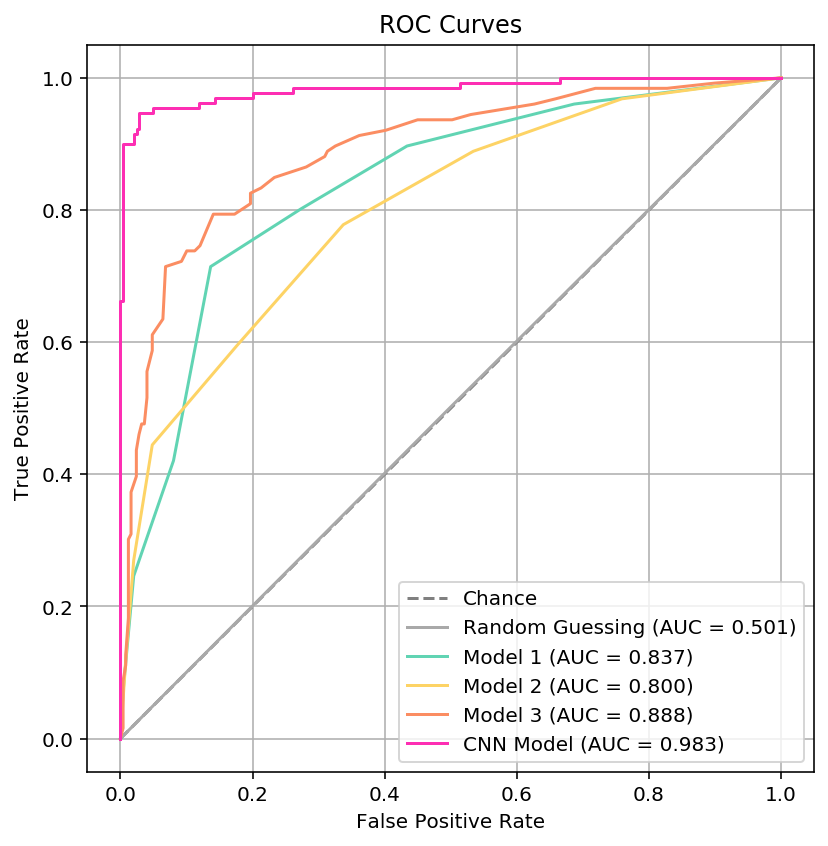

In [63]:
'''
Plotting ROC Curves for Performance on Validation Set
'''
# Compute and plot the ROC curves
plt.figure(figsize = (6, 6))
plt.title('ROC Curves')
plt.plot([0, 1], [0, 1], '--', color = 'gray', label = 'Chance')

# Plot ROC for each model
plot_roc(y_val, prediction_scores0v, legend = 'Random Guessing', color = 'darkgray')
plot_roc(y_val, prediction_scores1v, legend = 'Model 1', color = '#61d4b3')
plot_roc(y_val, prediction_scores2v, legend = 'Model 2', color = '#fdd365')
plot_roc(y_val, prediction_scores3v, legend = 'Model 3', color = '#fb8d62')
plot_roc(y_val4, prediction_scores4v, legend = 'CNN Model', color = '#fd2eb3')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid('on')
plt.axis('square')
plt.legend()
plt.tight_layout()

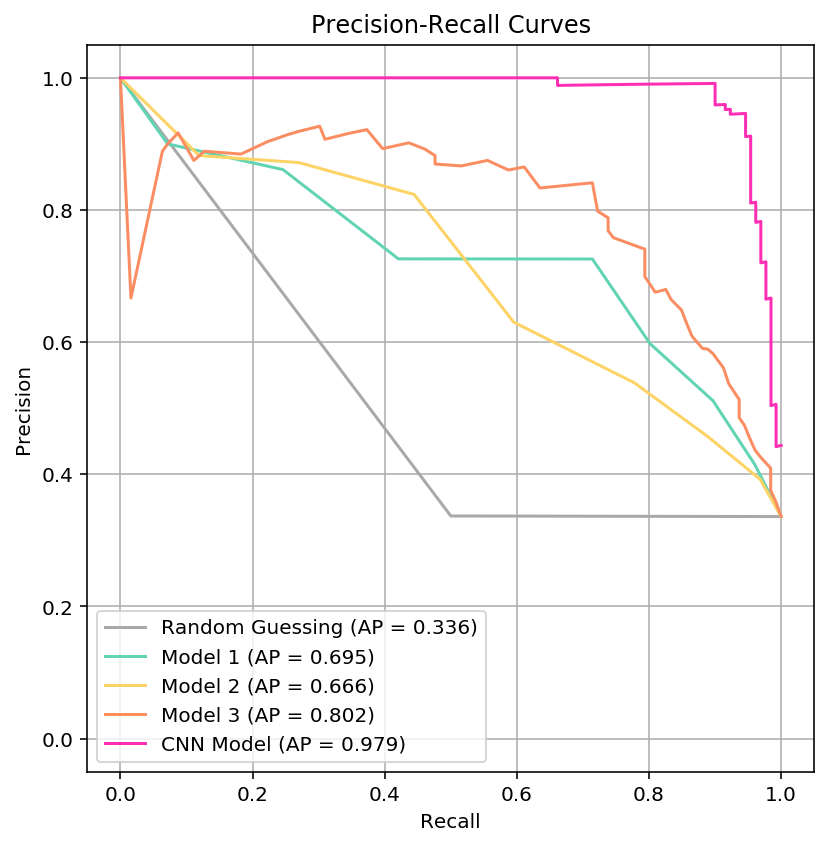

In [64]:
'''
Plotting PRC Curves for Performance on Validation Set
'''
# Compute and plot the PRC curves
plt.figure(figsize = (6, 6))
plt.title('Precision-Recall Curves')

# Plot ROC for each model
plot_prc(y_val, prediction_scores0v, legend = 'Random Guessing', color = 'darkgray')
plot_prc(y_val, prediction_scores1v, legend = 'Model 1', color = '#61d4b3')
plot_prc(y_val, prediction_scores2v, legend = 'Model 2', color = '#fdd365')
plot_prc(y_val, prediction_scores3v, legend = 'Model 3', color = '#fb8d62')
plot_prc(y_val4, prediction_scores4v, legend = 'CNN Model', color = '#fd2eb3')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid('on')
plt.axis('square')
plt.ylim(-0.05, 1.05)
plt.legend()
plt.tight_layout()

## 5. Kaggle Submissions

File creation for Kaggle submissions using test data predicted scores with every model trained on the full training dataset.

In [25]:
'''
Kaggle submission for Model 1
'''
# Load data, extract features, and train the classifier on the training data
training_features1 = preprocess_and_extract_features(X_train, prc1)
clf1.fit(training_features1, y_train)

# Load the test data and test the classifier
test_features1  = preprocess_and_extract_features(X_test, prc1)
test_scores1    = clf1.predict_proba(test_features1)[:, 1]

# Save the predictions to a CSV file for upload to Kaggle
submission_file = pd.DataFrame({'id':    ids_test,
                                'score': test_scores1})
submission_file.to_csv('../submission/submission1.csv',
                       columns = ['id', 'score'],
                       index = False)

In [26]:
'''
Kaggle submission for Model 2
'''
# Load data, extract features, and train the classifier on the training data
training_features2 = preprocess_and_extract_features(X_train, prc2)
clf2.fit(training_features2, y_train)

# Load the test data and test the classifier
test_features2  = preprocess_and_extract_features(X_test, prc2)
test_scores2    = clf2.predict_proba(test_features2)[:, 1]

# Save the predictions to a CSV file for upload to Kaggle
submission_file = pd.DataFrame({'id':    ids_test,
                                'score': test_scores2})
submission_file.to_csv('../submission/submission2.csv',
                       columns = ['id', 'score'],
                       index = False)

In [27]:
'''
Kaggle submission for Model 3
'''
# Load data, extract features, and train the classifier on the training data
training_features3 = Z_train
clf3.fit(training_features3, y_train)

# Load the test data and test the classifier
# Create test features Z with predictions scores from Model 1 and Model 2
Z_test = np.stack((test_scores1, test_scores2), axis = -1)
test_features3  = Z_test
test_scores3    = clf3.predict_proba(test_features3)[:, 1]

# Save the predictions to a CSV file for upload to Kaggle
submission_file = pd.DataFrame({'id':    ids_test,
                                'score': test_scores2})
submission_file.to_csv('../submission/submission3.csv',
                       columns = ['id', 'score'],
                       index = False)

## 6. Appendix

Code used to find the best values to filter the images for the color filtering method used for model 1.

In [28]:
def extract_colors(img, color_lo, color_hi):
    '''
    Function to test the color filtering method
    '''
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(img_hsv, color_lo, color_hi)
    #mask[mask == 0]  = 1 #filter out
    #mask[mask != 1]  = 0
    mask[mask != 0] = 1 #keep colors
    mask = np.expand_dims(mask, axis = 2)
    mask = np.append(np.append(mask, mask, axis = 2), mask, axis = 2)
    features = img * mask
    #features = np.mean(np.mean(features, axis = 0), axis = 0)
    
    if np.count_nonzero(features) != 0: 
        features = np.sum(np.sum(features, axis = 0), axis = 0) / np.count_nonzero(features)
    else:
        features = [0, 0, 0]
    return features

In [29]:
'''
Loop to calculate AUC for KNN models with different color filters
'''
aucs      = []
color_los = []
color_his = []

for r_lo in range(0, 1, 1):
    for r_hi in range(55, 66, 5):
        for g_lo in range(0, 1, 1):
            for g_hi in range(87, 98, 5):
                for b_lo in range(105, 116, 5):
                    for b_hi in range(187, 198, 5):
                        color_lo = np.asarray([r_lo, g_lo, b_lo])
                        color_hi = np.asarray([r_hi, g_hi, b_hi])
                        features = np.array([extract_colors(img, color_lo, color_hi) for img in X_train])
                        
                        knn = KNeighborsClassifier(n_neighbors = 7)
                        knn.fit(features, y_train)
                        scores = knn.predict_proba(features)[:, 1]
                        auc = metrics.roc_auc_score(y_train, scores)
                        
                        color_los.append((r_lo, g_lo, b_lo))
                        color_his.append((r_hi, g_hi, b_hi))
                        aucs.append(auc)

In [30]:
'''
Optimal colors approx.
'''
color_los[aucs.index(max(aucs))], color_his[aucs.index(max(aucs))]

((0, 0, 110), (55, 87, 187))

Sample images of each class.

In [31]:
'''
Random indexes for each class
'''
zeros = X_train[y_train == 0] # No solar panel
ones  = X_train[y_train == 1] # Solar panel

i_zeros = np.random.choice(zeros.shape[0], 5, replace = False)
i_ones  = np.random.choice(ones.shape[0],  5, replace = False)

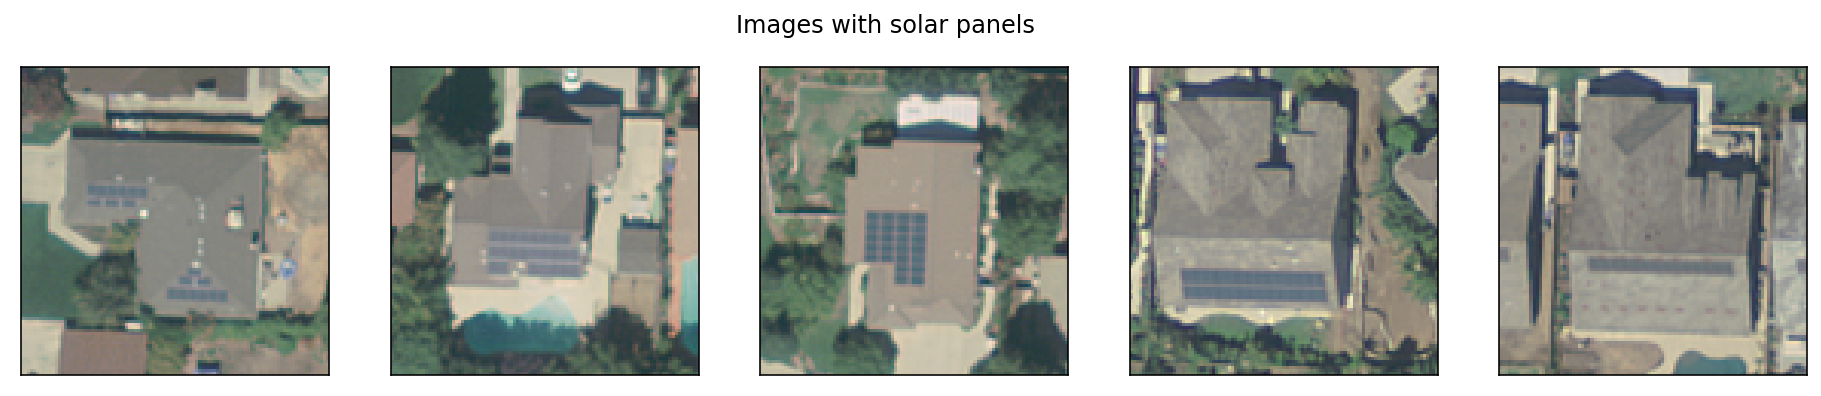

In [32]:
'''
Sample images with solar panels
'''
rcParams['figure.figsize'] = 16, 3
plt.figure()
plt.suptitle('Images with solar panels')

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(ones[i_ones[i]])
    plt.xticks([])
    plt.yticks([])

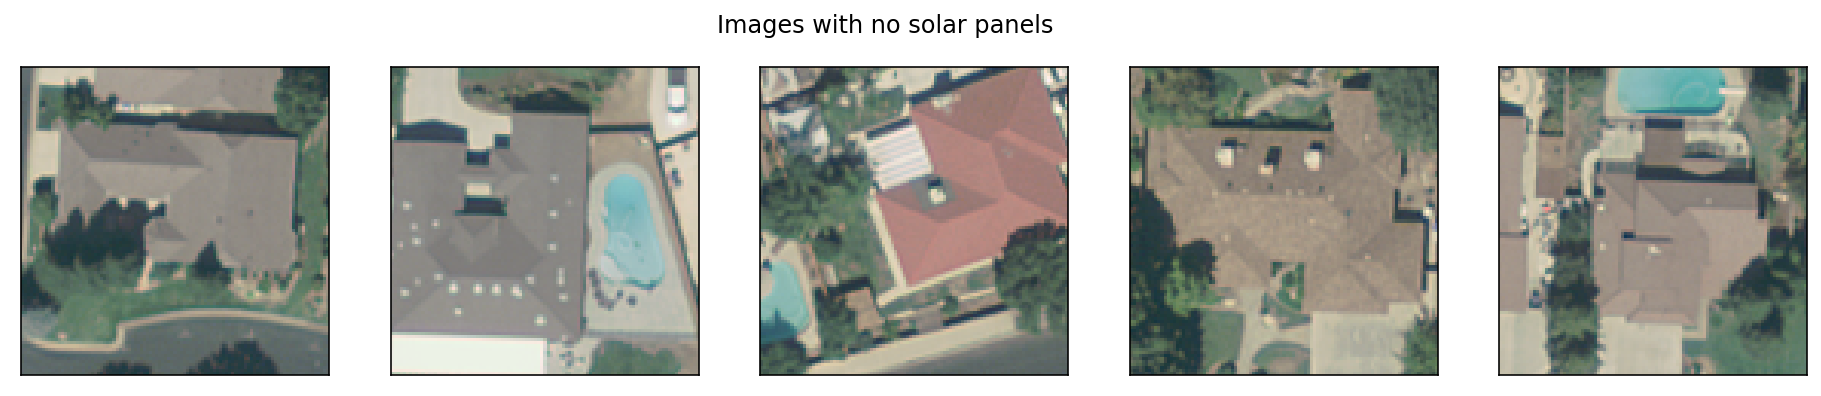

In [33]:
'''
Sample images with no solar panels
'''
rcParams['figure.figsize'] = 16, 3
plt.figure()
plt.suptitle('Images with no solar panels')

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(zeros[i_zeros[i]])
    plt.xticks([])
    plt.yticks([])

Sample images for color filter.

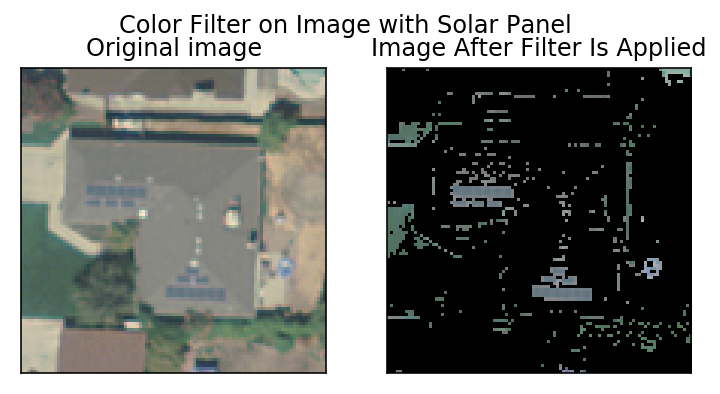

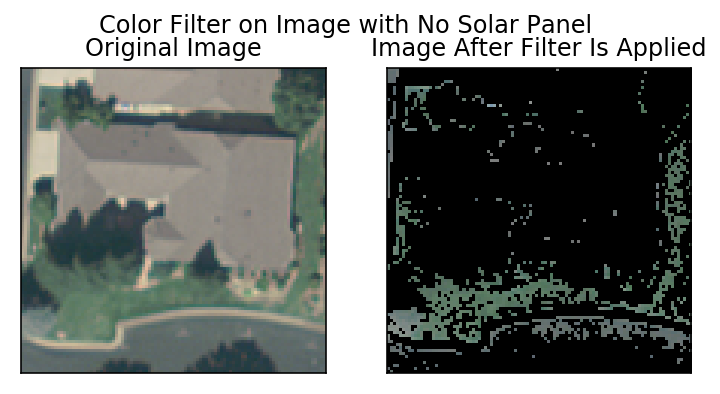

In [44]:
'''
Sample of color filtering used for Model 1
'''
img      = ones[i_ones[0]]
color_lo = np.asarray([0, 0, 110])   # Lower color
color_hi = np.asarray([55, 87, 187]) # Higher color

img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(img_hsv, color_lo, color_hi) # Create mask of pixels that are inside the color range
mask[mask != 0] = 1                             # Keep colors, turns every non black pixel into 1
mask = np.expand_dims(mask, axis = 2)
mask = np.append(
    np.append(mask, mask, axis = 2), 
    mask, 
    axis = 2
)
feature = img * mask                            # Turns every pixel outside the range into 0

rcParams['figure.figsize'] = 6, 3
plt.figure()
plt.suptitle('Color Filter on Image with Solar Panel')

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original image')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(feature)
plt.title('Image After Filter Is Applied')
plt.xticks([])
plt.yticks([])

plt.show()

img      = zeros[i_zeros[0]]
color_lo = np.asarray([0, 0, 110])   # Lower color
color_hi = np.asarray([55, 87, 187]) # Higher color

img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(img_hsv, color_lo, color_hi) # Create mask of pixels that are inside the color range
mask[mask != 0] = 1                             # Keep colors, turns every non black pixel into 1
mask = np.expand_dims(mask, axis = 2)
mask = np.append(
    np.append(mask, mask, axis = 2), 
    mask, 
    axis = 2
)
feature = img * mask  

rcParams['figure.figsize'] = 6, 3
plt.figure()
plt.suptitle('Color Filter on Image with No Solar Panel')

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(feature)
plt.title('Image After Filter Is Applied')
plt.xticks([])
plt.yticks([])

plt.show()

Sample images for HOG.

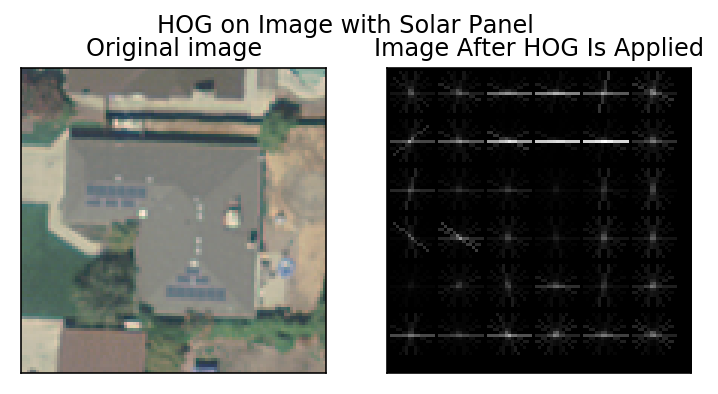

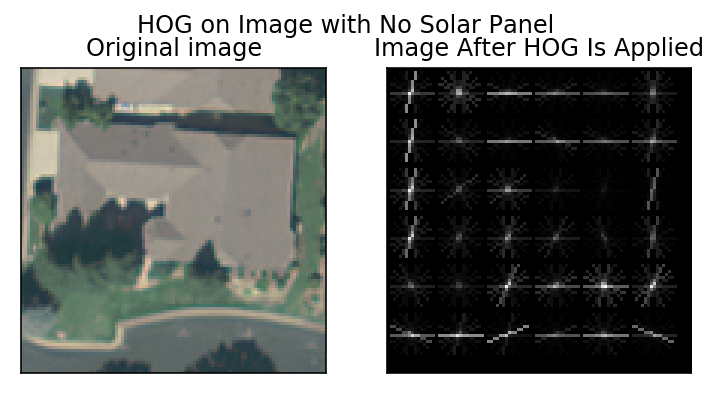

In [43]:
'''
Sample of HOG processing used for Model 2
'''
img         = ones[i_ones[0]]
fd, hog_img = hog(img, orientations = 9, pixels_per_cell = (16, 16),
                  cells_per_block = (4, 4), visualize = True, multichannel = True)

rcParams['figure.figsize'] = 6, 3
plt.figure()
plt.suptitle('HOG on Image with Solar Panel')

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original image')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(hog_img, cmap = plt.cm.gray)
plt.title('Image After HOG Is Applied')
plt.xticks([])
plt.yticks([])

plt.show()

img         = zeros[i_zeros[0]]
fd, hog_img = hog(img, orientations = 9, pixels_per_cell = (16, 16),
                  cells_per_block = (4, 4), visualize = True, multichannel = True)

rcParams['figure.figsize'] = 6, 3
plt.figure()
plt.suptitle('HOG on Image with No Solar Panel')

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original image')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(hog_img, cmap = plt.cm.gray)
plt.title('Image After HOG Is Applied')
plt.xticks([])
plt.yticks([])

plt.show()

Correctly and incorrectly classified images for each model.

In [37]:
'''
Getting indexes for True Positives, True Negatives, False Positives, False Negatives for each model
'''
# Model 1
i_tp1 = shuffle(np.where((y_val == predictions1v) * (y_val == 1))[0]) # Indexes of TPs
i_tn1 = shuffle(np.where((y_val == predictions1v) * (y_val == 0))[0]) # Indexes of TNs
i_fp1 = shuffle(np.where((y_val != predictions1v) * (y_val == 0))[0]) # Indexes of FPs
i_fn1 = shuffle(np.where((y_val != predictions1v) * (y_val == 1))[0]) # Indexes of FNs

# Model 2
i_tp2 = shuffle(np.where((y_val == predictions2v) * (y_val == 1))[0]) # Indexes of TPs
i_tn2 = shuffle(np.where((y_val == predictions2v) * (y_val == 0))[0]) # Indexes of TNs
i_fp2 = shuffle(np.where((y_val != predictions2v) * (y_val == 0))[0]) # Indexes of FPs
i_fn2 = shuffle(np.where((y_val != predictions2v) * (y_val == 1))[0]) # Indexes of FNs

# Model 3
i_tp3 = shuffle(np.where((y_val == predictions3v) * (y_val == 1))[0]) # Indexes of TPs
i_tn3 = shuffle(np.where((y_val == predictions3v) * (y_val == 0))[0]) # Indexes of TNs
i_fp3 = shuffle(np.where((y_val != predictions3v) * (y_val == 0))[0]) # Indexes of FPs
i_fn3 = shuffle(np.where((y_val != predictions3v) * (y_val == 1))[0]) # Indexes of FNs

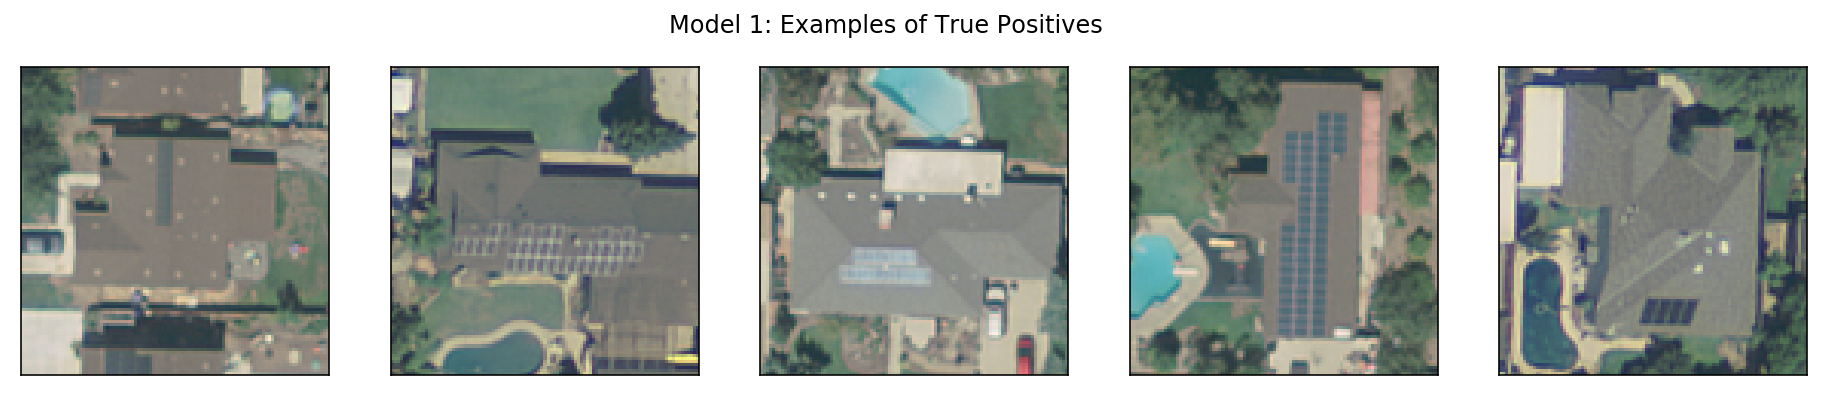

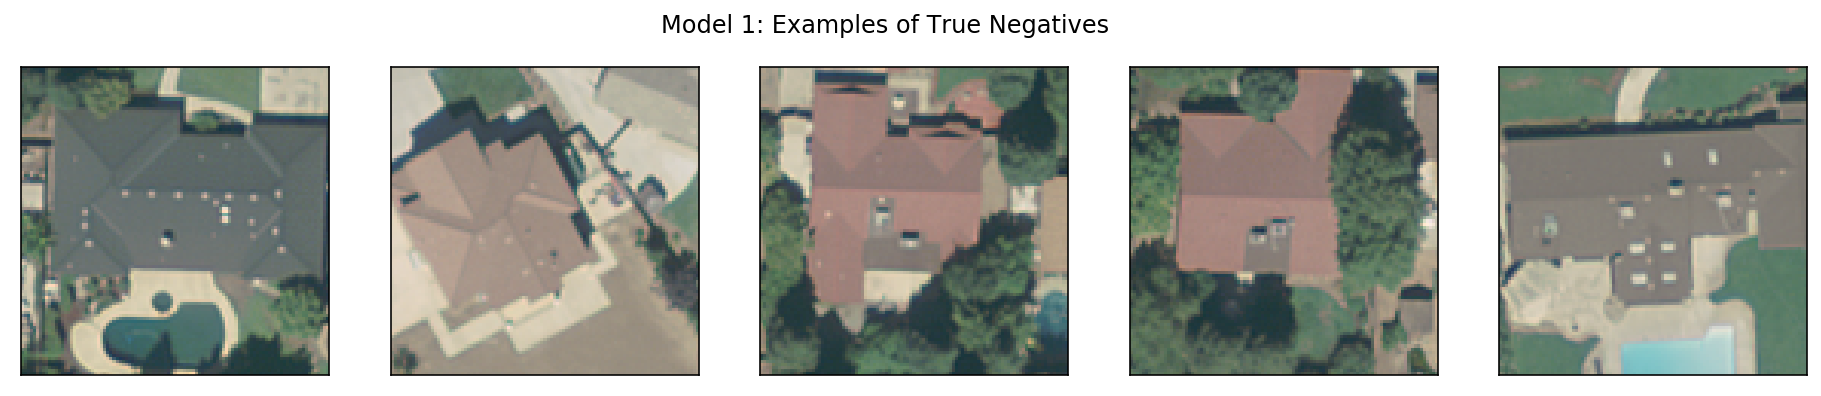

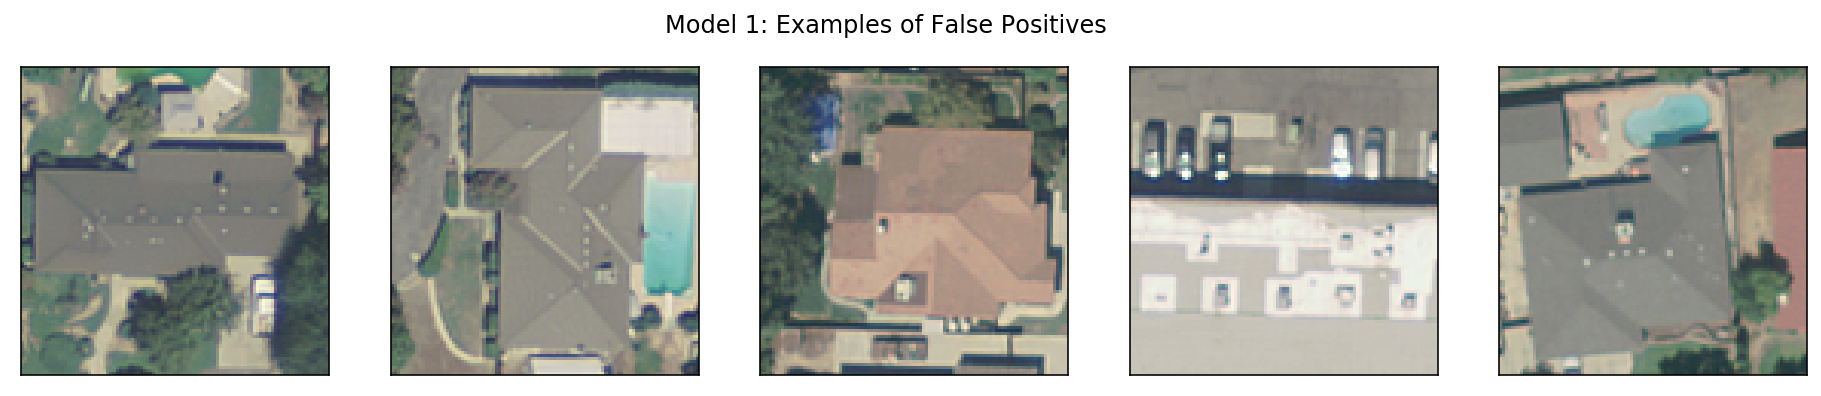

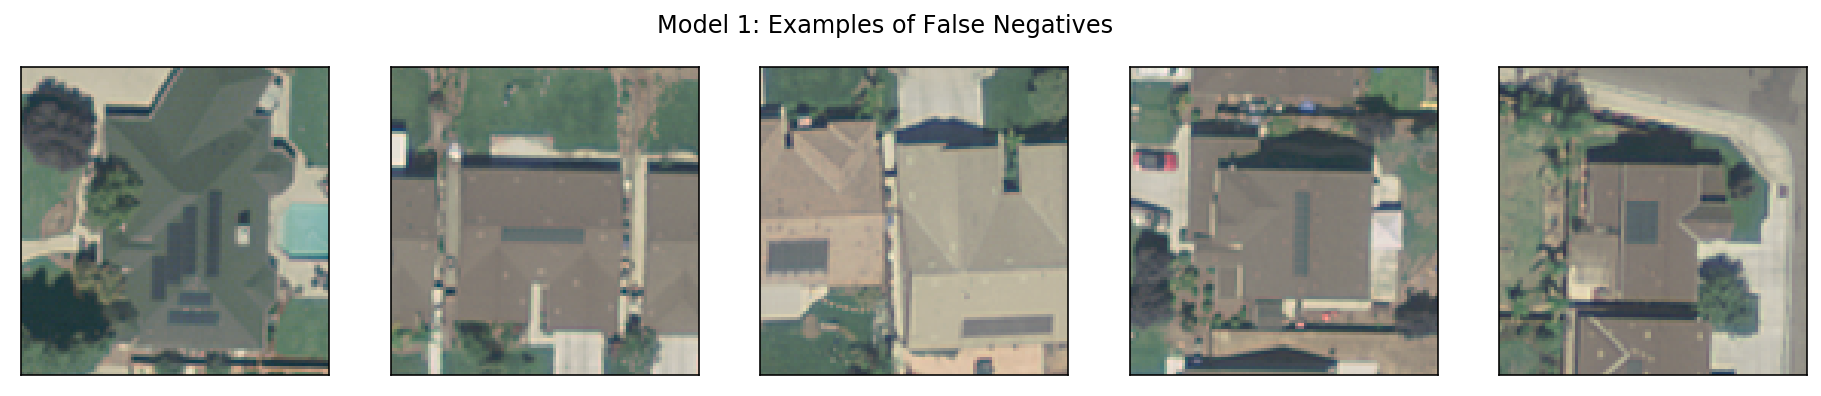

In [38]:
'''
Model 1: Correctly and incorrectly classified images on validation set examples
'''
rcParams['figure.figsize'] = 16, 3
plt.figure()
plt.suptitle('Model 1: Examples of True Positives')

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_val[i_tp1[i]])
    plt.xticks([])
    plt.yticks([])
    
rcParams['figure.figsize'] = 16, 3
plt.figure()
plt.suptitle('Model 1: Examples of True Negatives')

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_val[i_tn1[i]])
    plt.xticks([])
    plt.yticks([])
    
rcParams['figure.figsize'] = 16, 3
plt.figure()
plt.suptitle('Model 1: Examples of False Positives')

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_val[i_fp1[i]])
    plt.xticks([])
    plt.yticks([])
    
rcParams['figure.figsize'] = 16, 3
plt.figure()
plt.suptitle('Model 1: Examples of False Negatives')

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_val[i_fn1[i]])
    plt.xticks([])
    plt.yticks([])

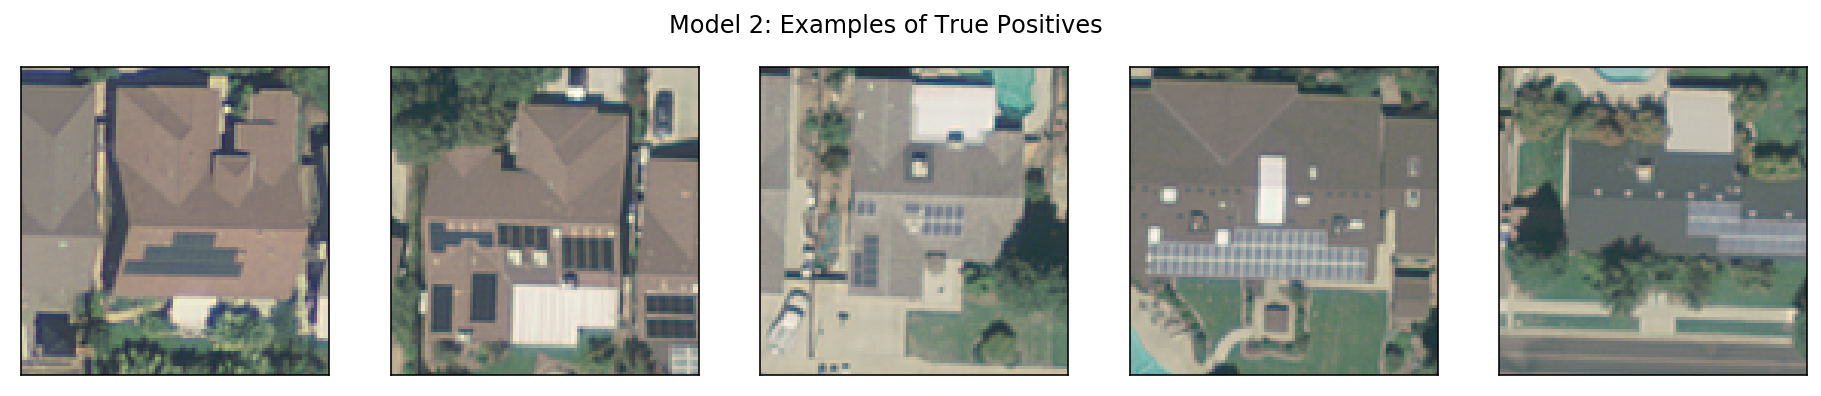

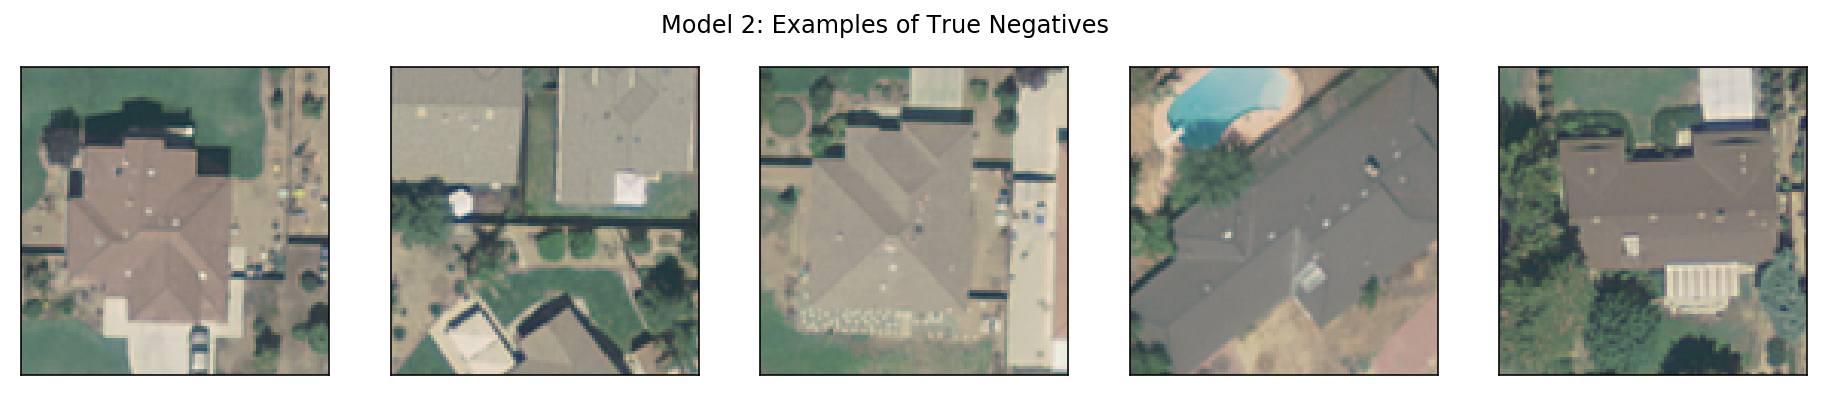

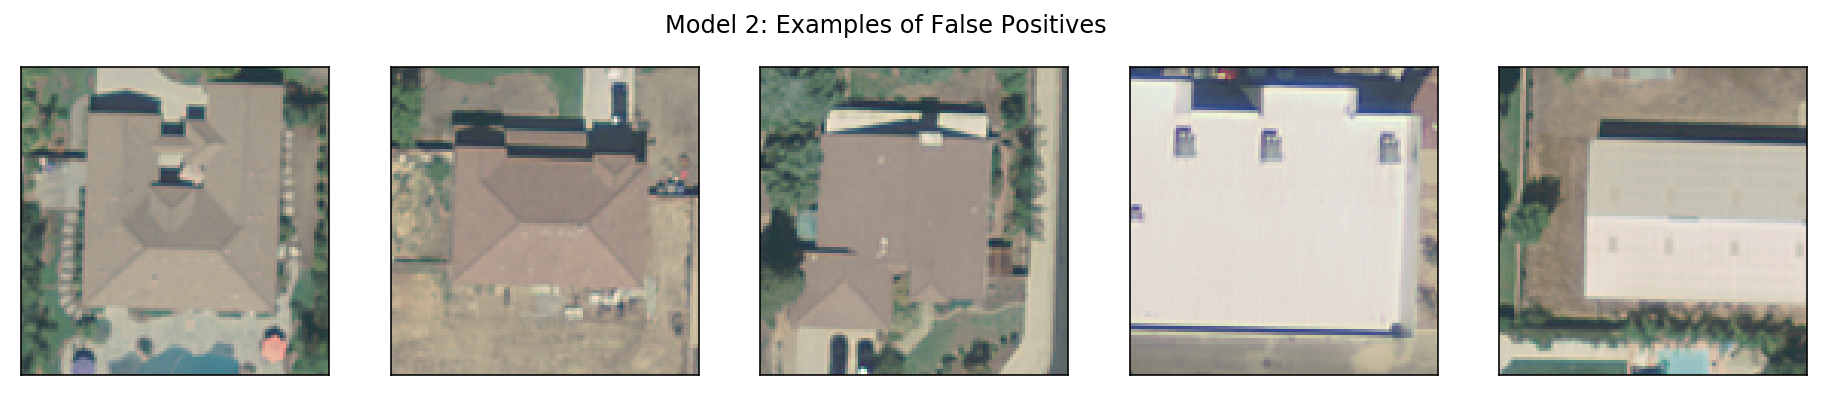

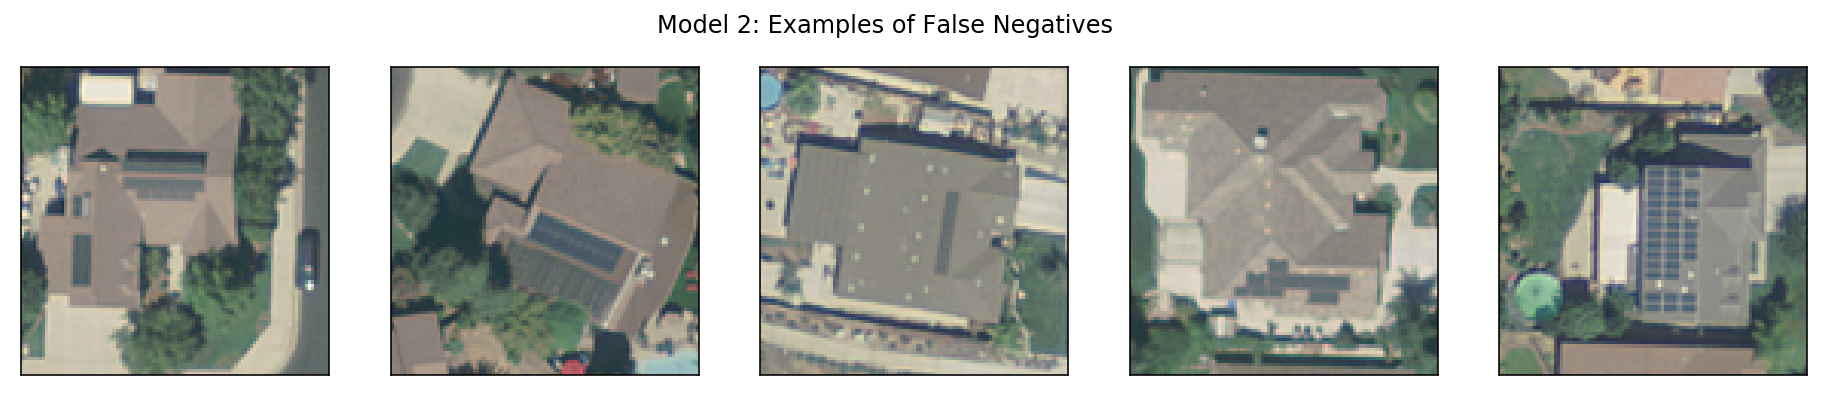

In [39]:
'''
Model 2: Correctly and incorrectly classified images on validation set examples
'''
rcParams['figure.figsize'] = 16, 3
plt.figure()
plt.suptitle('Model 2: Examples of True Positives')

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_val[i_tp2[i]])
    plt.xticks([])
    plt.yticks([])
    
rcParams['figure.figsize'] = 16, 3
plt.figure()
plt.suptitle('Model 2: Examples of True Negatives')

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_val[i_tn2[i]])
    plt.xticks([])
    plt.yticks([])
    
rcParams['figure.figsize'] = 16, 3
plt.figure()
plt.suptitle('Model 2: Examples of False Positives')

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_val[i_fp2[i]])
    plt.xticks([])
    plt.yticks([])
    
rcParams['figure.figsize'] = 16, 3
plt.figure()
plt.suptitle('Model 2: Examples of False Negatives')

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_val[i_fn2[i]])
    plt.xticks([])
    plt.yticks([])

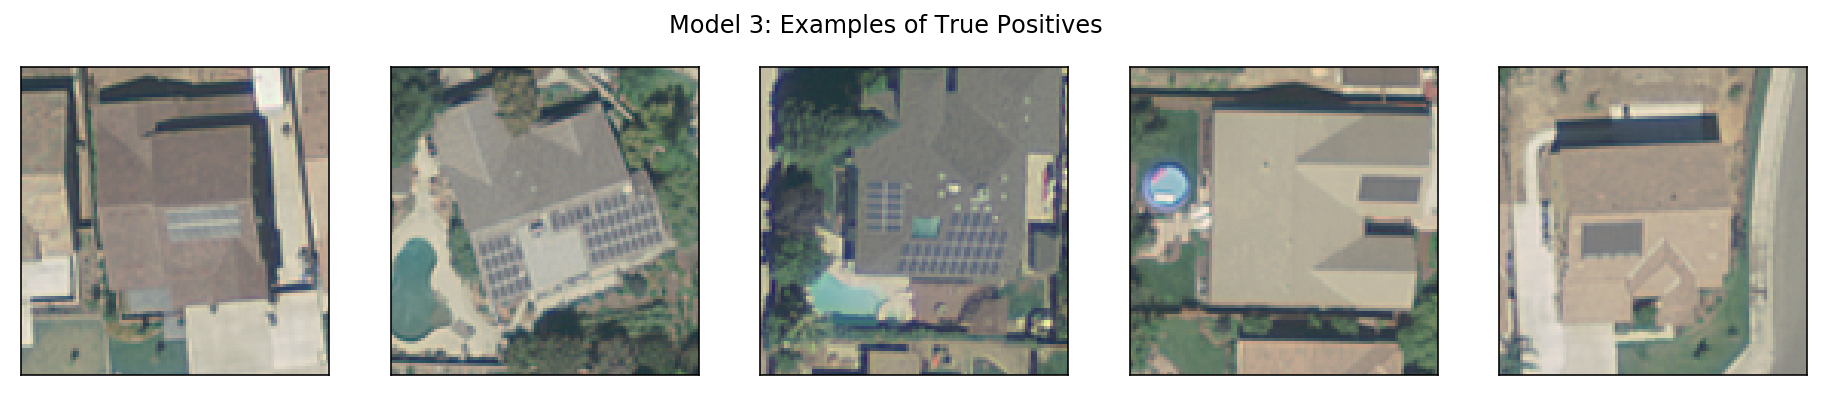

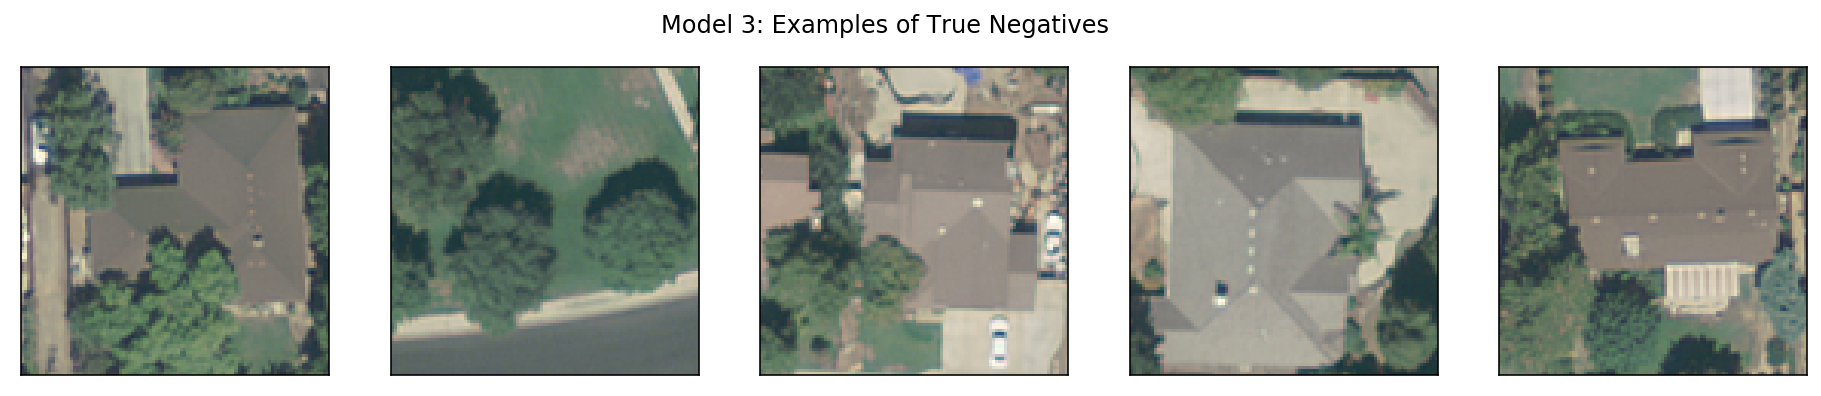

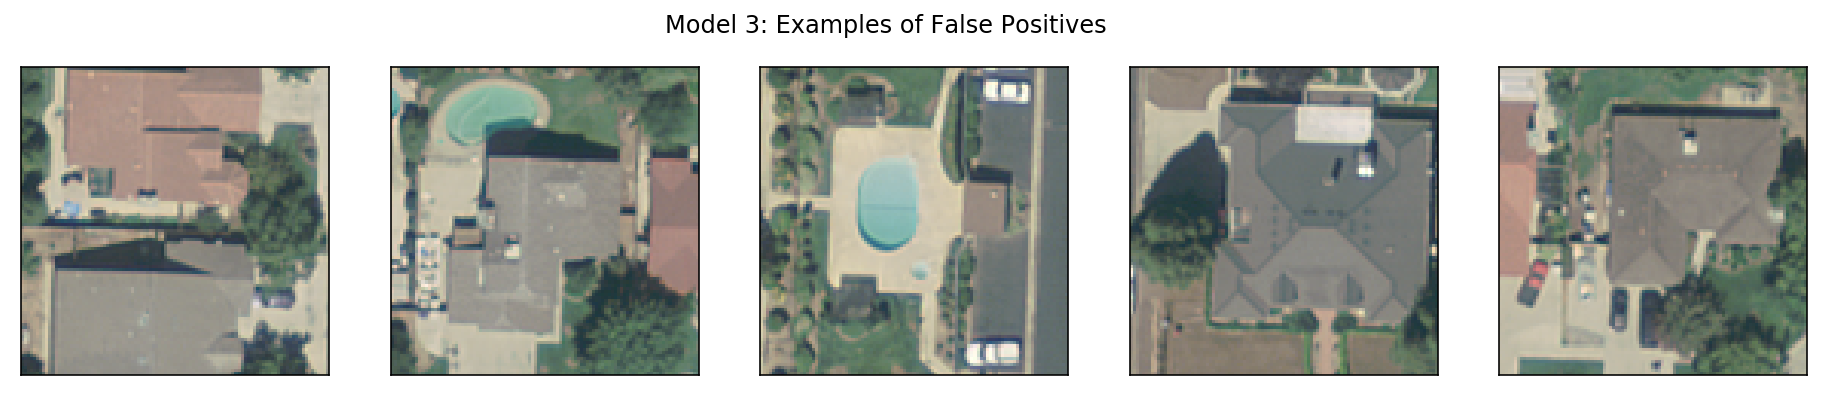

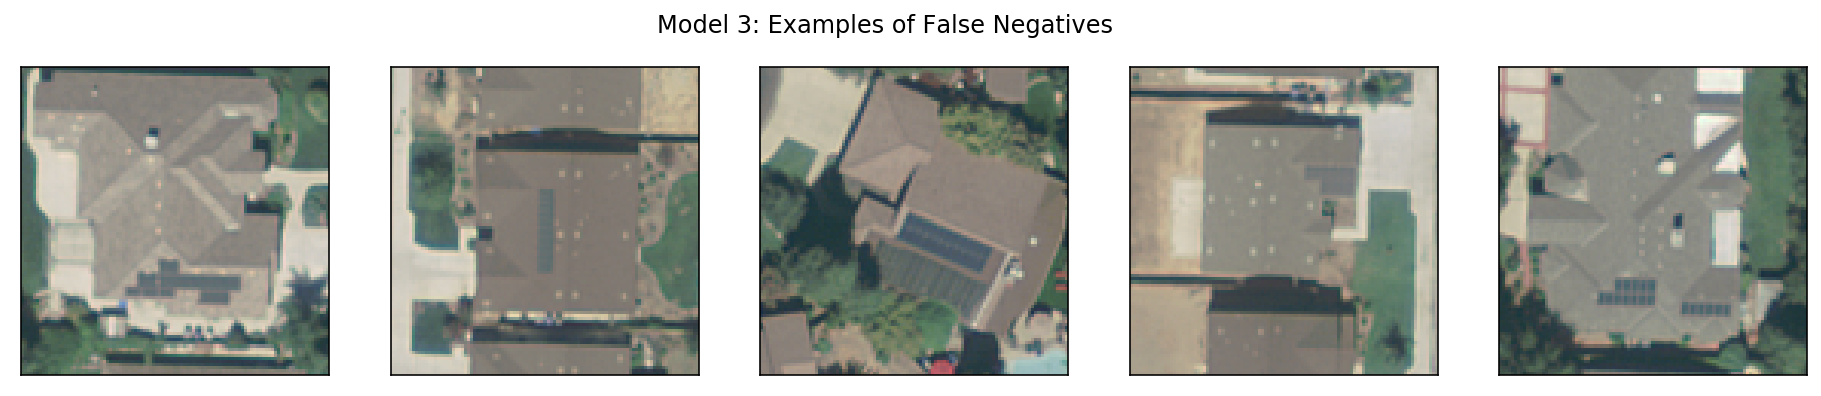

In [40]:
'''
Model 3: Correctly and incorrectly classified images on validation set examples
'''
rcParams['figure.figsize'] = 16, 3
plt.figure()
plt.suptitle('Model 3: Examples of True Positives')

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_val[i_tp3[i]])
    plt.xticks([])
    plt.yticks([])
    
rcParams['figure.figsize'] = 16, 3
plt.figure()
plt.suptitle('Model 3: Examples of True Negatives')

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_val[i_tn3[i]])
    plt.xticks([])
    plt.yticks([])
    
rcParams['figure.figsize'] = 16, 3
plt.figure()
plt.suptitle('Model 3: Examples of False Positives')

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_val[i_fp3[i]])
    plt.xticks([])
    plt.yticks([])
    
rcParams['figure.figsize'] = 16, 3
plt.figure()
plt.suptitle('Model 3: Examples of False Negatives')

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_val[i_fn3[i]])
    plt.xticks([])
    plt.yticks([])